Implementing Human Activity Recognition - Walking, walking downstairs, walking upstairs,sitting,standing,lying from the UCI dataset available at https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones.
The dataset contains values from the mobile phone sensors- Accelerometer and Gyroscope. These sensor values can help us predict the Human activities mentioned above. This model when trained with high accuracy can be used in mobile devices, smart watches to monitor users activity on daily basis. Based on the average activity of the user the user can be notified if he has performed some activity over or below the average. Another enhanced usecase for the activity recognition model would be to detect if the user is driving or biking. If the model detects these activities the user will be restricted from using some of the features on the smartphone for safety reasons.


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook

%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use(['seaborn-darkgrid'])
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

RANDOM_STATE = 17


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
Path = 'drive/My Drive/ML Assignments/dataset/HAR'

In [ ]:
X_train = np.loadtxt(Path+"/samsung_train.txt")
y_train = np.loadtxt(Path+"/samsung_train_labels.txt").astype(int)

X_test = np.loadtxt(Path+"/samsung_test.txt")
y_test = np.loadtxt(Path+"/samsung_test_labels.txt").astype(int)

In [ ]:
# Checking dimensions
assert(X_train.shape == (7352, 561) and y_train.shape == (7352,))
assert(X_test.shape == (2947, 561) and y_test.shape == (2947,))

In [ ]:
X = np.vstack([X_train, X_test])
y = np.hstack([y_train, y_test])

In [ ]:
np.unique(y)

array([1, 2, 3, 4, 5, 6])

In [ ]:
n_classes = np.unique(y).size

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Check the dimensions.

In [ ]:
pca = PCA(n_components=0.9, random_state=RANDOM_STATE).fit(X_scaled)
X_pca = pca.transform(X_scaled)

Execute the K-means alogorith on the clutsers. Since we have 6 different activities to detect the number of cluster would be 6.

In [ ]:
kmeans = KMeans(n_clusters=n_classes, n_init=100, 
                random_state=RANDOM_STATE, n_jobs=1)
kmeans.fit(X_pca)
centers = kmeans.cluster_centers_ 
cluster_labels = kmeans.labels_

Visuals define the clusters and the red dot represets the centroid of each cluster.

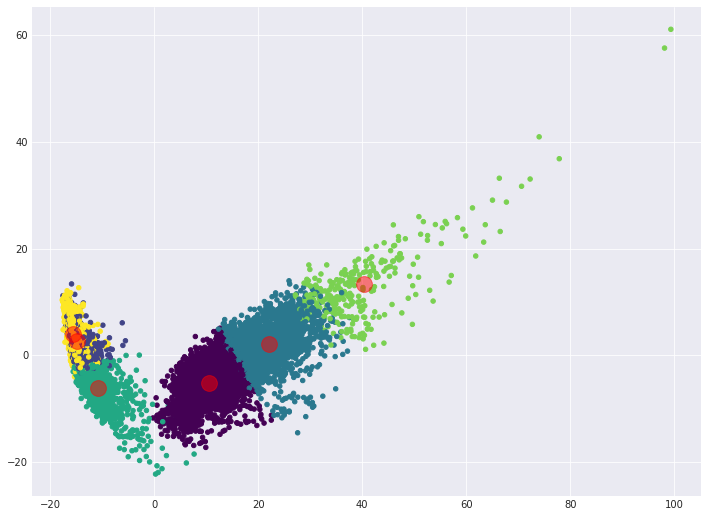

In [ ]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, s=20,  
            cmap='viridis');
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=250, alpha=0.5)

In [ ]:
tab = pd.crosstab(y, cluster_labels, margins=True)
tab.index = ['walking', 'going upstairs',
            'going down stairs', 'sitting', 'standing', 'lying', 'all']
tab.columns = ['cluster' + str(i + 1) for i in range(6)] + ['all']
tab

,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,all
walking,903,0,741,0,78,0,1722
going upstairs,1241,0,296,2,5,0,1544
going down stairs,320,0,890,0,196,0,1406
sitting,1,1235,0,450,0,91,1777
standing,0,1344,0,562,0,0,1906
lying,5,52,0,329,0,1558,1944
all,2470,2631,1927,1343,279,1649,10299


**Implementation using Tensorflow**


In [ ]:
import tensorflow as tf

Calculate the number of epochs

In [ ]:
def input_fn():
  return tf.compat.v1.train.limit_epochs(
      tf.convert_to_tensor(X_scaled, dtype=tf.float32), num_epochs=1)

In [ ]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
 
num_clusters = 6

kmeans = tf.compat.v1.estimator.experimental.KMeans(
    num_clusters=num_clusters, use_mini_batch=False)


num_iterations = 10
previous_centers = None
for _ in range(num_iterations):
    kmeans.train(input_fn)
    cluster_centers = kmeans.cluster_centers()
    if previous_centers is not None:
        print('delta:', cluster_centers - previous_centers)
    previous_centers = cluster_centers
    print('score:', kmeans.score(input_fn))
print('cluster centers:', cluster_centers)

#map input to respective clusters
cluster_indices = list(kmeans.predict_cluster_index(input_fn))
for i, point in enumerate(X_scaled):
    cluster_index = cluster_indices[i]
    center = cluster_centers[cluster_index]

score: 4371079.5
delta: [[-0.9037891   0.25987515  0.17270437 ...  0.26906472  0.11158055
   0.2687762 ]
 [-0.03734295  0.09954105 -0.05415991 ...  1.0606213  -0.8587902
  -0.8522539 ]
 [-1.0157608   0.19099057 -1.0286855  ...  0.13898993  0.03445697
   0.09743279]
 [-0.76484567 -0.973658   -0.24207398 ... -0.25646955 -0.33188885
  -0.23710299]
 [ 1.3947992   1.17409    -0.04758246 ...  0.02677485  0.28241742
   0.9415127 ]
 [ 0.01695974  0.16925137  0.50468564 ...  1.2569011  -0.6604939
  -0.35523397]]
score: 2763764.8
delta: [[ 0.0041132   0.03112428  0.05715013 ... -0.00898403  0.0084776
  -0.00307143]
 [ 0.0085362  -0.01528888 -0.01426548 ... -0.03241375  0.05450037
  -0.01646349]
 [-0.00743476 -0.00984941 -0.046055   ... -0.00768143 -0.02124834
  -0.01365176]
 [ 0.05435399  0.00871798  0.01349461 ... -0.03548917 -0.02371866
  -0.0199427 ]
 [ 0.07597199  0.09173637  0.04424439 ... -0.00125909  0.01974156
   0.05791125]
 [ 0.00351628 -0.02233819 -0.00706533 ...  0.08316579 -0.177370

In [ ]:
centers = kmeans.cluster_centers()
centers

array([[ 0.02489574,  0.04647106,  0.02195375, ..., -0.5146414 ,
         0.50915825,  0.50179887],
       [-0.01586087,  0.09324755,  0.08124784, ...,  0.11248846,
        -0.1451556 , -0.28059343],
       [ 0.16007462, -0.04796252, -0.01056917, ..., -0.47807097,
         0.55437285,  0.44560704],
       [ 0.04904473, -0.07017702, -0.10460537, ..., -0.45724973,
         0.54674035,  0.64069045],
       [-0.18713726, -0.15570939, -0.11667345, ..., -0.35904682,
         0.5742886 ,  0.48375782],
       [ 0.03139545,  0.02438288,  0.00963971, ...,  0.5671176 ,
        -0.7009053 , -0.5086932 ]], dtype=float32)

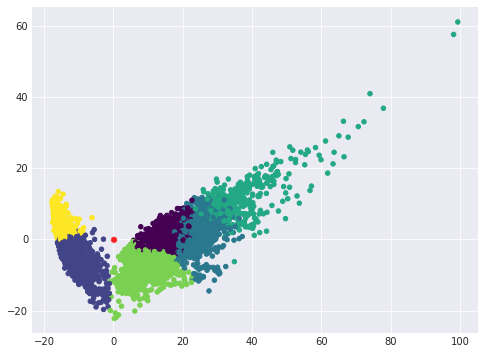

In [ ]:

plt.subplots(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_indices, s=20, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=20, alpha=0.25);

From the above Clustering we can infer that the values from accelerometer and gyroscope in between a certain range can predict the human activity. For example if the accelerometer value(x-axis) is in between 0-17 and the Gyroscope value(y-axis) is in the range of -18 to -2 the person is Walking. The yellow cluster represents the walking activity. Similarly, we can derive inference for other activities - walking downstairs, walking upstairs, lying,sitting and standing in the same way.